In [88]:
pip install python-math

Note: you may need to restart the kernel to use updated packages.


In [89]:
import numpy as np
import quimb as qu
import quimb.tensor as qtn

# Tree-TensorNetwork

Following https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.155131

### Definition

<img src="./images/diagram_TTN.png" alt="Example Image" width="1000" style="display: block; margin-left: auto; margin-right: auto;" />

As illustrated in Fig. 1(b), each circle represents
a tensor; each edge of the circle represents an individual
index of the tensor. The first tensor is a matrix connecting the
second and third tensors, while the remaining tensors are all
three-order tensors with three indices. The index between two
tensors is called a virtual bond, which would be contracted
hereafter. The left and right indices of the tensors in the
bottom of the TTN are respectively connected to two pixels
of the input image and hence are called physical bonds.

The bond dimension in a tensor network refers to the dimension of the shared index (or bond) connecting two tensors. 
Higher bond dimensions allow more complex entanglement between subsystems to be represented. In quantum many-body systems, the bond dimension represents the number of states used to approximate the entanglement structure.

Since bond dimension represents on how many indices we are summing, it is related to how well we can represent states with our tensor network.
In the context of Matrix Product States (MPS), the bond dimension directly corresponds to the Schmidt rank of the state for each bipartition. If the bond dimension is h , the MPS can capture states with a maximum Schmidt rank of h.

$|\psi\rangle=\sum_{i=1}^D \lambda_i\left|u_i\right\rangle_A \otimes\left|v_i\right\rangle_B$, where D is the Schmidt rank, the number of non-zero $\lambda$, which quantifies the enganglement between the two subsystems A and B (for D=1 the state is separable).

In [90]:
def build_ttn(number_physical_indexes, bond_dimension, number_layers):
    #
    # this function builds a tree tensor network with the specified number of physical indexes, bond dimension and number of layers
    # the tree tensor network is composed of number_layers layers of rank-3 random tensors halving the number at each layer
    # the function returns the tensor network, a matrix of tensors composing it and the list of lenghts of each layer
    # root is considered a layer and the function does not check if the number of physical indexes is compatible with the number of layers
    #
    ttn_shape = [int(number_physical_indexes / (2 ** (i + 1))) for i in range(number_layers)]
    
    index = [[] for _ in range(number_layers)]
    index[0] = [f'ph{i}' for i in range(number_physical_indexes)]
    for i in range(1, number_layers):
        index[i] = [f'b{i-1}{j}' for j in range(ttn_shape[i-1])]
    
    tensor = [[] for _ in range(number_layers)]
    tensor[0] = [qtn.rand_tensor([bond_dimension] * 3, inds=[index[0][2 * i], index[0][2 * i + 1], index[1][i]], tags=f't0{i}') for i in range(ttn_shape[0])]
    for i in range(1, number_layers - 1):
        tensor[i] = [qtn.rand_tensor([bond_dimension] * 3, inds=[index[i][2 * j], index[i][2 * j + 1], index[i + 1][j]], tags=f't{i}{j}') for j in range(ttn_shape[i])]
    tensor[number_layers - 1] = [qtn.rand_tensor([bond_dimension] * 2, inds=[index[number_layers - 1][2 * k], index[number_layers - 1][2 * k + 1]], tags=f't{number_layers - 1}{k}') for k in range(ttn_shape[number_layers - 1])]
    
    return qtn.TensorNetwork(tensor), tensor, ttn_shape

In [91]:
number_physical_indexes = 16
bond_dimension = 2
number_layers = 4

tensor_network, tensor, ttn_shape = build_ttn(number_physical_indexes, bond_dimension, number_layers)

In [92]:
# we can access tags of tensors with tensor_map
#  for name, specs in tensor_network.tensor_map.items():
#     print(f"Tensor name: {name}")
#     print(f"Description: {tensor}")
#     print() 

In [93]:
# tensor_network.draw(show_inds=True,show_tags=True)

We can contract the whole tensor network and calculate the forbenius norm of the resulting rank-8 tensor.

In [94]:
# contracted = tensor_network.contract(all, optimize='auto-hq')
# contracted.draw(color=['t0','t1','t2'],show_inds=True,show_tags=True)
# print('norm: ',contracted.norm())

### Canonizing

We can now procede in canonicalization procedure for each layer of the TNN, taking the root tensor as central tensor. In this procedure we have to keep an eye on indexes, since the QR decomposition, the first block of indices is assigned to Q and the second one (in our case, the only "upper" one) is assigned to R, to be contracted with the next layer. The algorithm creates a new set of indexes beetween the first and second layer, that we have to rename.

<div style="text-align: center;">
    <img src="./images/canonize-bond.png" alt="Example Image" width="1500" style="display: block; margin-left: auto; margin-right: auto;"/>
    <p>The arrow on U means it's unitary</p>
</div>

Quimb has a default algorith to canonize bonds

In [95]:
for i in range(ttn_shape[1]):
    qtn.tensor_canonize_bond(tensor[0][2*i], tensor[1][i])
    qtn.tensor_canonize_bond(tensor[0][2*i+1], tensor[1][i])
for i in range(ttn_shape[2]):
    qtn.tensor_canonize_bond(tensor[1][2*i], tensor[2][i])
    qtn.tensor_canonize_bond(tensor[1][2*i+1], tensor[2][i])

In [96]:
# print('root norm: ',tensor[2][0].norm())

In [97]:
# contracted = tensor_network.contract(all, optimize='auto-hq')
# contracted.draw(color=['t0','t1','t2'],show_inds=True,show_tags=True)
# print(contracted.norm())

Canonization preserves Forbenius norm and the norm of the whole tensor network is given by the norm of the root.

### Perfect sampling algorithm

https://tensornetwork.org/mps/algorithms/sampling/ here the example is aplied to MPS but can be generalized to other TNs, including TTN

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.155131 chapter II-F

https://journals.aps.org/prb/pdf/10.1103/PhysRevB.85.165146


We can assume our probability distribution to be:
$$p\left(s_1, s_2, s_3, \ldots, s_N\right)=\left|T^{s_1 s_2 s_3 \cdots s_N}\right|^2$$
First we need to make sure it is normalized to one.
$$\sum_{\{s\}}\left|T^{s_1 s_2 s_3 \cdots s_N}\right|^2=1 \text {, or }$$

In [98]:
# tensor_network = tensor_network / tensor_network.norm()

The principle underlying the MPS sampling algorithm below is the “chain rule” of probability

$$p\left(s_1, s_2, s_3, \ldots, s_N\right)=p\left(s_1\right) p\left(s_2 \mid s_1\right) p\left(s_3 \mid s_1 s_2\right) \cdots p\left(s_N \mid s_1 s_2 s_3 \cdots s_{N-1})\right.$$

computing each factor on the right we will get a single sample from the full distribution.

Let' start with $P(s_1)$
$$p\left(s_1\right)=\sum_{s_2, s_3, \ldots, s_N} p\left(s_1, s_2, \ldots, s_N\right)=\sum_{s_2, s_3, \ldots, s_N} T^{s_1 s_2 \cdots s_N} \bar{T}^{s_1 s_2 \ldots s_N}$$

<div style="text-align: center;">
    <img src="./images/image3.png" alt="Sampling Algorithm Image" width="600" style="display: block; margin-left: auto; margin-right: auto;" />
</div>

In [99]:
# step_tensor_network = tensor_network.H.reindex({'ph0':'ph0*'})&tensor_network
# step_tensor_network.draw(color=['t00'],show_tags=True)

In [100]:
# reduced_tensor_network = step_tensor_network.contract(all)
# reduced_tensor_network.draw(color=['t00'],show_inds=True,show_tags=True)

The result is a matrix (“reduced density matrix”), but here we will only need its diagonal elements, ph0=ph0*. 
Contracting with the basis elements (0,1) and (1,0) we get $p(s_0)$ and $p(s_1)$. It must hold $p(s_0)+p(s_1)=1$. Drawing a value from this probability distribution is equivalent to extract a value in $r\in[0,1]$ and if $r<p_1$ then $\hat{s_1}=(0,1)$ and viceversa.

In [101]:
# v0 = qtn.Tensor(data=[0,1], inds=['ph0'])
# v1 = qtn.Tensor(data=[1,0], inds=['ph0'])
# ps0 = v0@reduced_tensor_network@v0.reindex({'ph0':'ph0*'})
# ps1 = v1@reduced_tensor_network@v1.reindex({'ph0':'ph0*'})
# print('ps0: ',ps0)
# print('ps1: ',ps1)
# print('normalization check: ',ps0+ps1)
# r = np.random.uniform(0, 1)
# print('random number: ', r)
# s_hat = [[]]
# if r < ps0:
#     s_hat[0] = v0.data
# else:
#     s_hat[0] = v1.data
# print('s_hat vector: ', s_hat[0])

Now we can contract the tensor network with s0 and repeat the process for $s_2$, to compute $p(s_2|\hat s_1)$, and so on to $p(\hat s_N,....,\hat s_1)$

In [102]:
# v = qtn.Tensor(data=s_hat[0], inds=['ph0'])
# step_tensor_network = step_tensor_network @ v.reindex({'ph0':'ph0*'}) @ v

I will write it down again in one algorithm for convenience

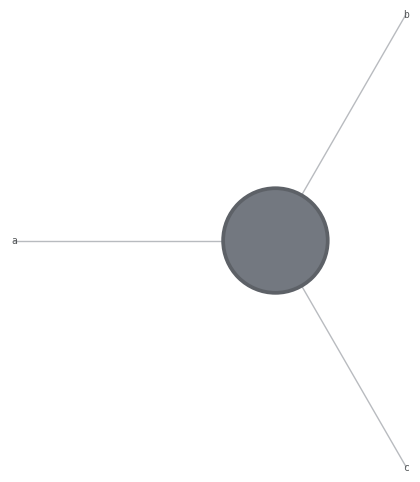

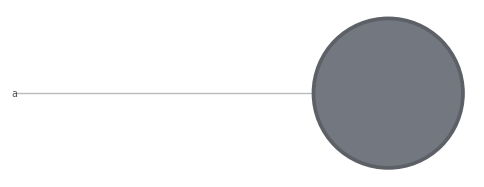

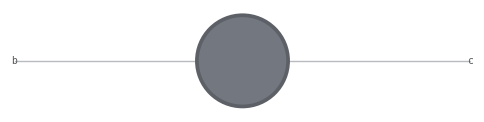

In [103]:
random_tensor1 = qtn.rand_tensor([bond_dimension] * 3, inds=['a', 'b', 'c'])
random_tensor2 = qtn.rand_tensor([bond_dimension] * 1, inds=['a'])
tensor3 = random_tensor1 @ random_tensor2
random_tensor1.draw()
random_tensor2.draw()
tensor3.draw()

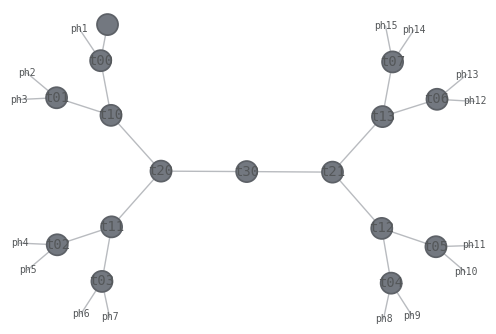

In [104]:
v = qtn.Tensor(data=[0,1], inds=['ph0'])
aaa = tensor_network & v
aaa.draw()

In [105]:
tensor_network = tensor_network / tensor_network.norm()

errore al ciclo:  1
errore al ciclo:  2
errore al ciclo:  3
errore al ciclo:  4
errore al ciclo:  5
errore al ciclo:  6
errore al ciclo:  7
errore al ciclo:  8
errore al ciclo:  9
errore al ciclo:  10
errore al ciclo:  11
errore al ciclo:  12
errore al ciclo:  13
errore al ciclo:  14
errore al ciclo:  15
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


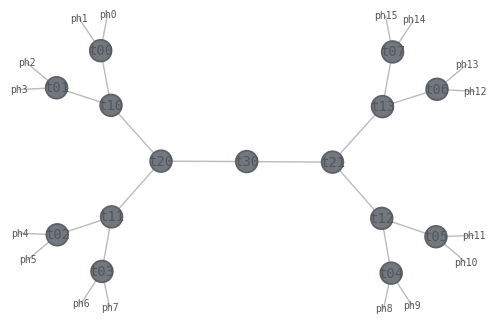

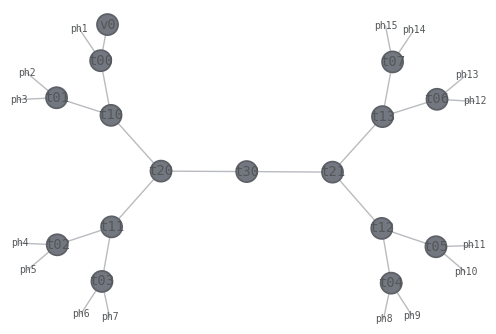

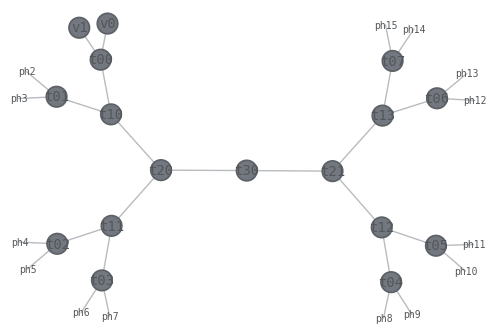

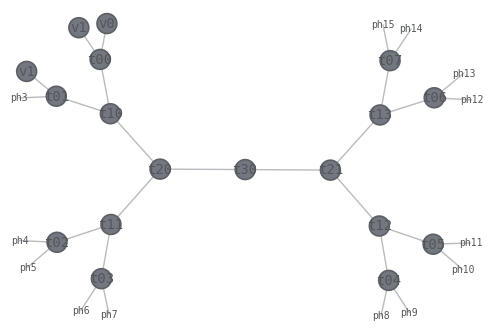

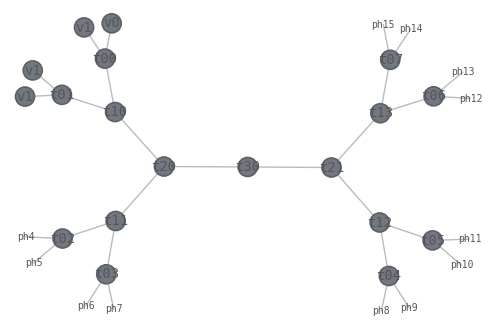

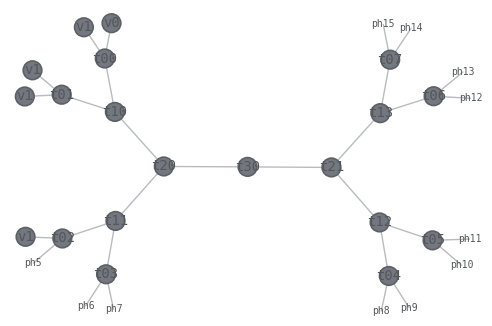

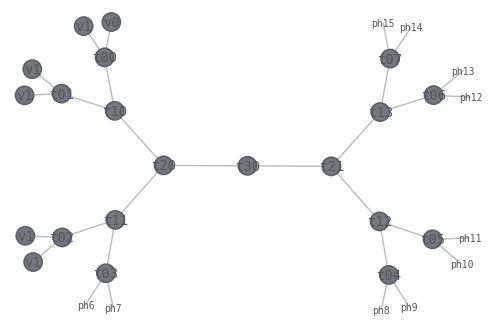

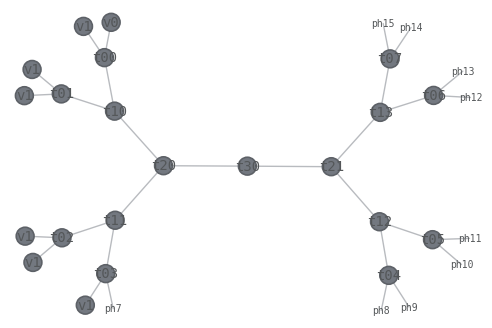

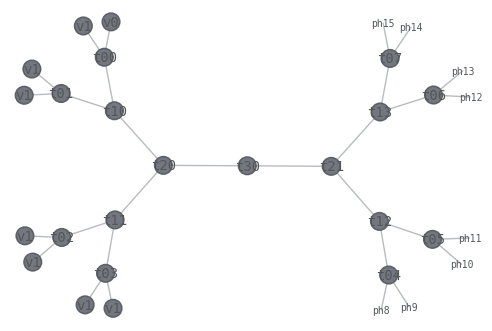

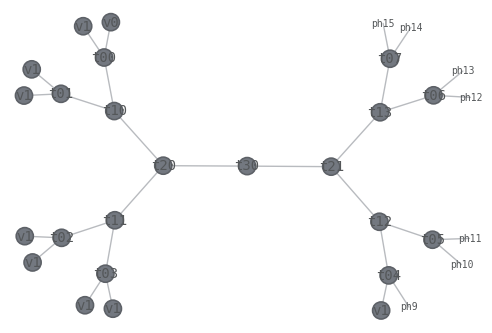

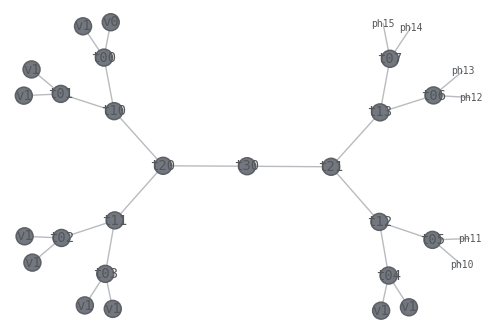

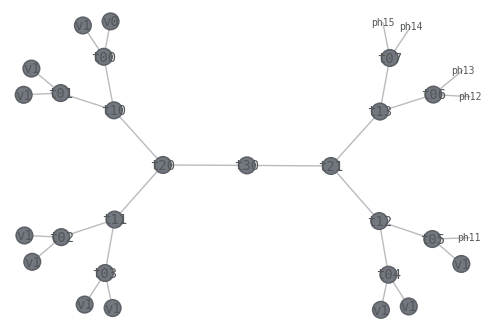

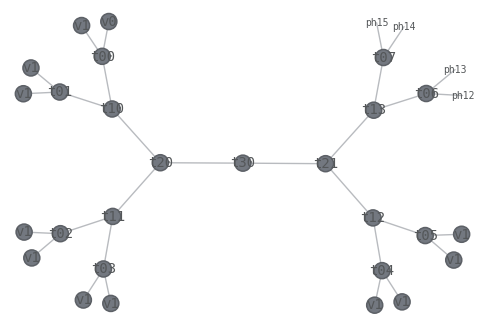

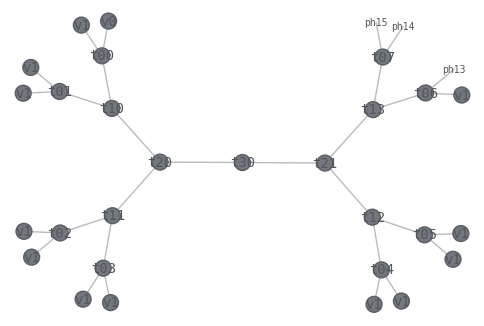

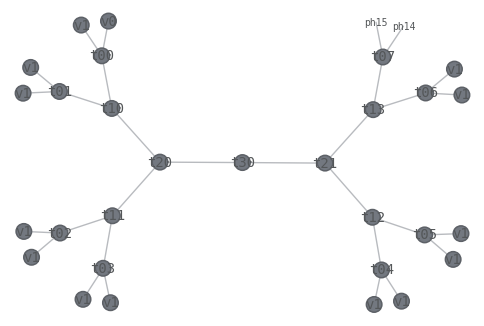

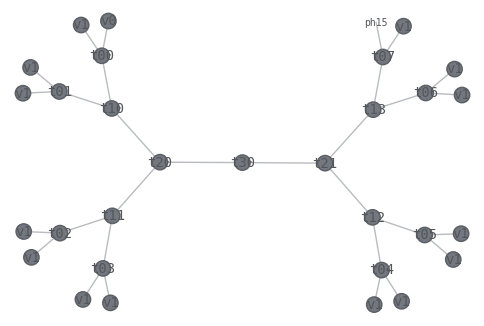

In [137]:
s_hat = np.zeros([16,2])

for i in range(16):
    step_tensor_network = tensor_network

    for j in range(i): 
        v = qtn.Tensor(data=s_hat[j], inds=[f'ph{j}'], tags=[f'v{int(s_hat[j][0])}'])
        step_tensor_network = step_tensor_network & v
    
    fig = step_tensor_network.draw(return_fig=True)
    fig.savefig(f'{i}.png', bbox_inches='tight', dpi=300)    
    
    step_tensor_network_full = step_tensor_network.H.reindex({f'ph{i}':f'ph{i}*'}) & step_tensor_network
    reduced_tensor_network = step_tensor_network_full.contract(all)

    v0 = qtn.Tensor(data=[0,1], inds=[f'ph{i}'])
    v1 = qtn.Tensor(data=[1,0], inds=[f'ph{i}'])
    
    ps0 = v0 @ reduced_tensor_network @ v0.reindex({f'ph{i}':f'ph{i}*'})
    ps1 = v1 @ reduced_tensor_network @ v1.reindex({f'ph{i}':f'ph{i}*'})

    if ps0+ps1!=1:
        print("errore al ciclo: ",i)
        #break

    r = np.random.uniform(0, 1)
    if r < ps0:
        s_hat[i] = v0.data
    else:
        s_hat[i] = v1.data
print(s_hat)